This code contains data pre-processing steps for Emotion recognition classification task.
Dataset: SEED

Two methods of DL:
Pure DL: Without Feature Extraction.
Hubrid DL: With feature extraction using sepctrograms


In [ ]:

import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
    AveragePooling2D, Dropout, BatchNormalization,
    Activation, Flatten, Dense
) # EEG NET is not a built-in model in Keras
from tensorflow.keras.constraints import max_norm
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,f1_score,roc_auc_score



In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) #force_remount will refresh if the files is moved.


Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Emotion_EEG/EEG_Features.zip" -d "/content/drive/MyDrive/Emotion_EEG/Extracted"


replace /content/drive/MyDrive/Emotion_EEG/Extracted/EEG_Features/DE/sub000.pkl.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Files has DE folder and PSD folder

In [ ]:



ROOT_PATH = "/content/drive/MyDrive/Emotion_EEG/Extracted/EEG_Features/DE"

# Check if the folder exists
if os.path.exists(ROOT_PATH):
    print("Root path found")
    print("Files inside:", os.listdir(ROOT_PATH)[:10])  # show first 10 files
else:
    print("Root path does not exist. Check the directory name!")


Root path found ✔
Files inside: ['sub000.pkl.pkl', 'sub001.pkl.pkl', 'sub002.pkl.pkl', 'sub003.pkl.pkl', 'sub004.pkl.pkl', 'sub005.pkl.pkl', 'sub006.pkl.pkl', 'sub007.pkl.pkl', 'sub008.pkl.pkl', 'sub009.pkl.pkl']


next step: Check the arrangement and labelling of the folder in .pkl

In [5]:
import pickle # This used to load and save the data in numpyarray as .pkl file.


sample = "/content/drive/MyDrive/Emotion_EEG/Extracted/EEG_Features/DE/sub000.pkl.pkl"  # change name if different
# Open sample file, rb= read binary, and name it as a single letter f which can be called later.
with open(sample, 'rb') as f:
    load_sample = pickle.load(f)

print(type(load_sample))
print(np.array(load_sample).shape)


<class 'numpy.ndarray'>
(28, 32, 30, 5)


(28, 32, 30, 5)
28 trials (videos)
32 channels
30 time segments PER TRIAL
5 frequency bands

= 28 × 30 = 840 samples per subject per electrode

5 freq bands = 160 DE values per sample

840 samples × 160 DE values
= 134,400 DE values per subject




# Next step: Read all the files.

In [ ]:


ROOT_PATH = "/content/drive/MyDrive/Emotion_EEG/Extracted/EEG_Features/DE/"

all_subject_DE = []   # list to store each subject DE array

for file_name in sorted(os.listdir(ROOT_PATH)):
    if file_name.endswith('.pkl'):  # Only .pkl files
        file_path = os.path.join(ROOT_PATH, file_name)
        print(f"Loading: {file_name}")

        try:
            with open(file_path, 'rb') as f:
                subject_data = pickle.load(f)  # should be numpy array

            subject_data = np.array(subject_data)

            # Check dimensionality (expecting 28×32×30×5)
            if subject_data.ndim == 4:
                all_subject_DE.append(subject_data)
            else:
                print(f"Skipping {file_name}: unexpected shape {subject_data.shape}")

        except Exception as e:
            print(f"Failed to load {file_name}: {e}")

# Stack into final array if files were loaded
if len(all_subject_DE) > 0:
    de_data = np.stack(all_subject_DE, axis=0)
    print("\nSuccessfully loaded DE data!")
    print("Total subjects loaded:", de_data.shape[0])
    print("Per subject DE shape:", de_data.shape[1:])  # expected (28, 32, 30, 5)
    print("Full DE dataset shape:", de_data.shape)      # (Subjects, 28, 32, 30, 5)
else:
    print("No DE .pkl files found.")


Loading: sub000.pkl.pkl
Loading: sub001.pkl.pkl
Loading: sub002.pkl.pkl
Loading: sub003.pkl.pkl
Loading: sub004.pkl.pkl
Loading: sub005.pkl.pkl
Loading: sub006.pkl.pkl
Loading: sub007.pkl.pkl
Loading: sub008.pkl.pkl
Loading: sub009.pkl.pkl
Loading: sub010.pkl.pkl
Loading: sub011.pkl.pkl
Loading: sub012.pkl.pkl
Loading: sub013.pkl.pkl
Loading: sub014.pkl.pkl
Loading: sub015.pkl.pkl
Loading: sub016.pkl.pkl
Loading: sub017.pkl.pkl
Loading: sub018.pkl.pkl
Loading: sub019.pkl.pkl
Loading: sub020.pkl.pkl
Loading: sub021.pkl.pkl
Loading: sub022.pkl.pkl
Loading: sub023.pkl.pkl
Loading: sub024.pkl.pkl
Loading: sub025.pkl.pkl
Loading: sub026.pkl.pkl
Loading: sub027.pkl.pkl
Loading: sub028.pkl.pkl
Loading: sub029.pkl.pkl
Loading: sub030.pkl.pkl
Loading: sub031.pkl.pkl
Loading: sub032.pkl.pkl
Loading: sub033.pkl.pkl
Loading: sub034.pkl.pkl
Loading: sub035.pkl.pkl
Loading: sub036.pkl.pkl
Loading: sub037.pkl.pkl
Loading: sub038.pkl.pkl
Loading: sub039.pkl.pkl
Loading: sub040.pkl.pkl
Loading: sub041.

Valence mapping is created uisng the Valence labelling from Task_event file and Trial index in DE .pkl file.

In [11]:
VALENCE_DICT = {
    1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: -1,
    7: -1, 8: -1, 9: -1, 10: -1, 11: -1, 12: -1,
    13: 0, 14: 0, 15: 0, 16: 0,
    17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1,
    23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1
}

X_all = []
Y_all = [] # Initialize y_all here

for DE in all_subject_DE:         # Iterate list of DE arrays
    for trial_idx in range(DE.shape[0]):  # 0..27
        val = VALENCE_DICT[trial_idx + 1]

        if val == 0:
            continue  # skip neutral

        X_all.append(DE[trial_idx])
        Y_all.append(val) # Append the corresponding label


# Convert to numpy
X_all = np.stack(X_all)
Y_all = np.array(Y_all) # Convert y_all to numpy array




print("X_all shape:", X_all.shape)
print("Y_all shape:", Y_all.shape)

X_all shape: (2952, 32, 30, 5)
Y_all shape: (2952,)


2952= 28*123. 28 trials in 123 subjects. 2952 Samples in total.

Input to CNN:
   height  = 32     (electrodes)
   width   = 30     (time segments)
   channels = 5     (frequency bands)

   So, 4200 input neurons in total


In [14]:


# y_all is already created earlier from your trial mapping
# Example: y_all = np.array([0,1,0,1,...])

# --------------------------------
# Convert y_all → y_binary

# --------------------------------
binary_label_map = {
    -1: 0,   # negative  → 0
     1: 1    # positive  → 1
}

# If y_all already contains 0/1, this line just keeps them unchanged
y_binary = np.array([binary_label_map.get(val, val) for val in Y_all])

print("Sample binary labels:", y_binary[:10])
print("Binary shape:", y_binary.shape)

# --------------------------------
# One-Hot Encode
# --------------------------------
num_classes = 2
y_onehot = np.eye(num_classes)[y_binary]

print("Sample one-hot vectors:\n", y_onehot[:5])
print("One-hot shape:", y_onehot.shape)




Sample binary labels: [0 0 0 0 0 0 0 0 0 0]
Binary shape: (2952,)
Sample one-hot vectors:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
One-hot shape: (2952, 2)


In [16]:


# Normalize DE features globally across all subjects/trials
mean = X_all.mean(axis=(0, 1, 2), keepdims=True)
std  = X_all.std(axis=(0, 1, 2), keepdims=True) + 1e-6
X_all_norm = (X_all - mean) / std

print("New normalized shape:", X_all_norm.shape)

# Then replace X_all with X_all_norm in all future steps


New normalized shape: (2952, 32, 30, 5)


average across samples

average across channels

average across time windows

BUT NOT across the frequency band dimension.
Normalization shrinks SCALE, not PATTERN.
Normalization preserves the “shape” of signals.
Normalization helps the model learn relative changes, not absolute amplitude

Split the data into train and test.
This is a random subject split.

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X_all_norm, y_onehot,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y_binary  # Ensure balanced class split
)

print("Train:", X_train.shape, y_train.shape)
print("Test:",  X_test.shape, y_test.shape)




Train: (2361, 32, 30, 5) (2361, 2)
Test: (591, 32, 30, 5) (591, 2)


In [18]:


def build_eegnet(input_shape=(32, 30, 5), num_classes=2,
                 F1=8, D=2, kernLength=16, dropout_rate=0.5):
    """
    EEGNet-style model (Lawhern et al., 2018) adapted for:
    input_shape = (channels=32, time=30, bands=5), channels_last.
    """
    inputs = Input(shape=input_shape)

    # Block 1: Temporal Convolution
    x = Conv2D(
        filters=F1,
        kernel_size=(1, kernLength),
        padding='same',
        use_bias=False
    )(inputs)
    x = BatchNormalization()(x)

    # Block 1: Depthwise Convolution (spatial filter across channels)
    x = DepthwiseConv2D(
        kernel_size=(input_shape[0], 1),  # span all 32 channels
        depth_multiplier=D,
        use_bias=False,
        depthwise_constraint=max_norm(1.)
    )(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D(pool_size=(1, 4))(x)
    x = Dropout(dropout_rate)(x)

    # Block 2: Separable Convolution (further temporal–spectral filtering)
    F2 = F1 * D  # as in EEGNet paper
    x = SeparableConv2D(
        filters=F2,
        kernel_size=(1, 16),
        padding='same',
        use_bias=False
    )(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D(pool_size=(1, 2))(x) # Changed pool_size from (1, 8) to (1, 2)
    x = Dropout(dropout_rate)(x)

    # Classification layer
    x = Flatten()(x)
    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_constraint=max_norm(0.25)
    )(x)

    model = Model(inputs=inputs, outputs=outputs, name="EEGNet_FACED")
    return model

In [19]:
input_shape = (32, 30, 5)   # (channels, time, bands)
num_classes = 2

model = build_eegnet(input_shape=input_shape, num_classes=num_classes)
model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',   # because y is one-hot
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")


Model: "EEGNet_FACED"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 30, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 30, 8)      │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 30, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 30, 16)      │           512 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 30, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 30, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 7, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 7, 16)       │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 7, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 3, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            98 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,922 (7.51 KB)

 Trainable params: 1,842 (7.20 KB)

 Non-trainable params: 80 (320.00 B)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5192 - loss: 0.7038 - val_accuracy: 0.5008 - val_loss: 0.6942
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5539 - loss: 0.6873 - val_accuracy: 0.5567 - val_loss: 0.6904
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5588 - loss: 0.6798 - val_accuracy: 0.5550 - val_loss: 0.6936
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5919 - loss: 0.6667 - val_accuracy: 0.5499 - val_loss: 0.6821
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6245 - loss: 0.6576 - val_accuracy: 0.5550 - val_loss: 0.6781
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6349 - loss: 0.6535 - val_accuracy: 0.5854 - val_loss: 0.6852
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6193 - loss: 0.6501 - val_accuracy: 0.5888 - val_loss: 0.6704
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6511 - loss: 0.6388 - val_accuracy: 0.6058 - v

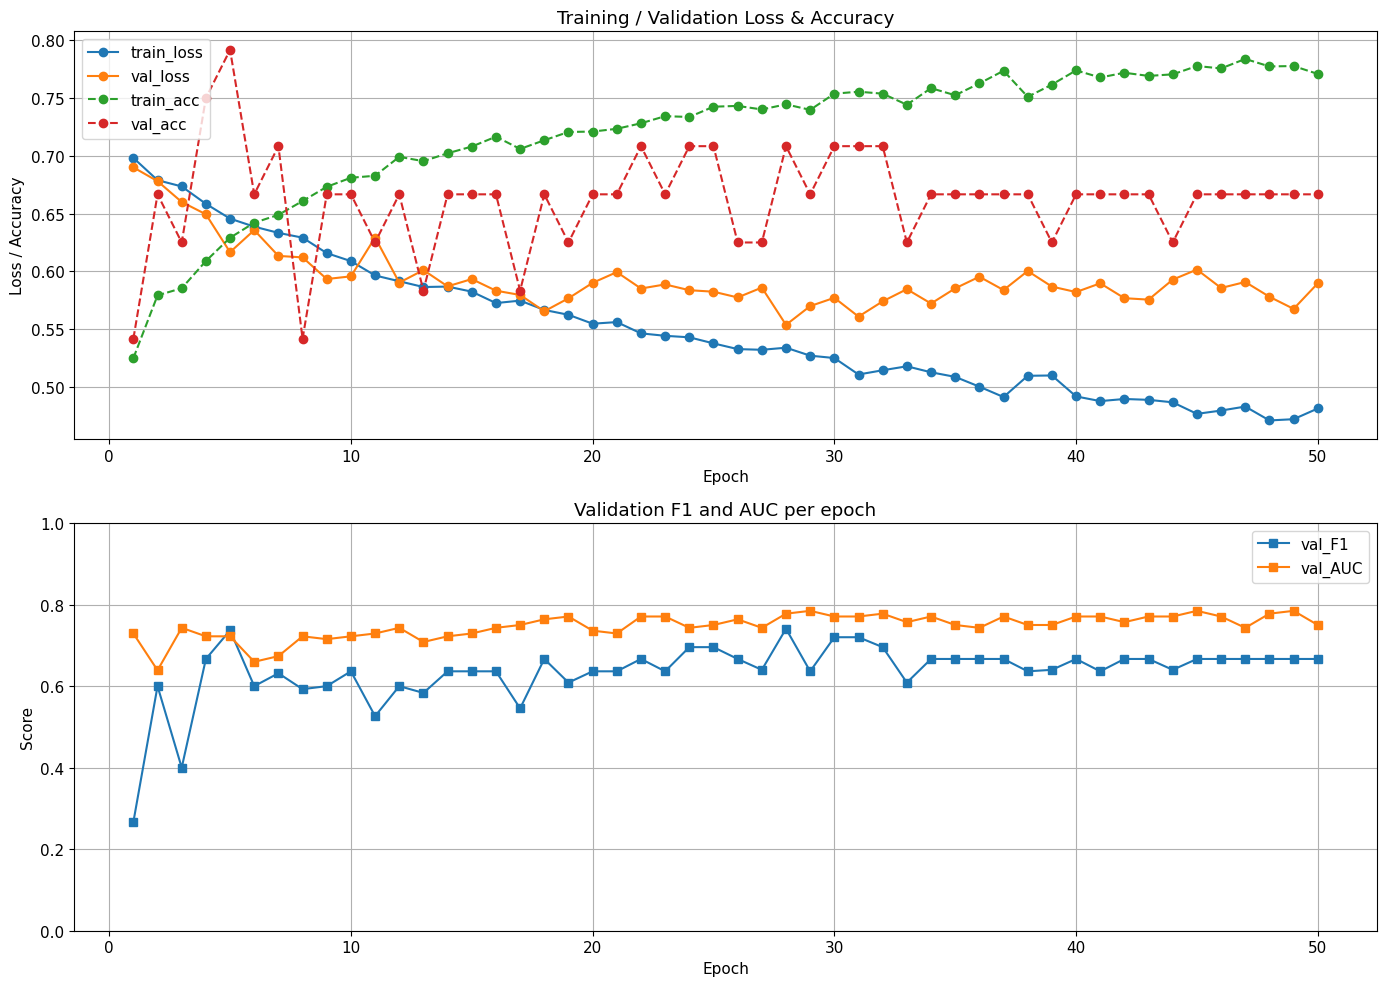


Classification report (validation):
              precision    recall  f1-score   support

           0     0.6667    0.6667    0.6667        12
           1     0.6667    0.6667    0.6667        12

    accuracy                         0.6667        24
   macro avg     0.6667    0.6667    0.6667        24
weighted avg     0.6667    0.6667    0.6667        24

Confusion matrix:
 [[8 4]
 [4 8]]


In [ ]:
###Learning curves in Random split
epochs_ran = range(1, len(history.history['loss']) + 1)
hist = history.history

plt.figure(figsize=(14, 10))

# Plot loss & accuracy
plt.subplot(2, 1, 1)
plt.plot(epochs_ran, hist['loss'], 'o-', label='train_loss')
plt.plot(epochs_ran, hist['val_loss'], 'o-', label='val_loss')
# accuracy metric might be 'sparse_categorical_accuracy' or 'accuracy'
acc_key = 'accuracy' # 'accuracy' is used in model.compile
if acc_key in hist:
    plt.plot(epochs_ran, hist[acc_key], 'o--', label='train_acc')
    plt.plot(epochs_ran, hist['val_' + acc_key], 'o--', label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.grid(True)
plt.title('Training / Validation Loss & Accuracy')


val_f1 = hist.get('val_f1', metrics_cb.val_f1s)
val_auc = hist.get('val_auc', metrics_cb.val_aucs)

plt.subplot(2, 1, 2)
plt.plot(epochs_ran, val_f1, 's-', label='val_F1')
plt.plot(epochs_ran, val_auc, 's-', label='val_AUC')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim(0.0, 1.0)
plt.legend()
plt.grid(True)
plt.title('Validation F1 and AUC per epoch')

plt.tight_layout()
plt.show()

# -------------------------
# Final evaluation on validation set: classification report + confusion matrix
# -------------------------
# Get final predictions
preds = model.predict(X_val, batch_size=64, verbose=0)

# Convert y_val from one-hot to class labels for classification_report and confusion_matrix
y_val_labels = np.argmax(y_val, axis=1)

if preds.ndim == 1 or preds.shape[-1] == 1:
    probs = preds.ravel()
    y_pred = (probs >= 0.5).astype(int)
else:
    probs = preds[:, 1] if preds.shape[1] > 1 else preds.ravel()
    y_pred = np.argmax(preds, axis=1)

print("\nClassification report (validation):")
print(classification_report(y_val_labels, y_pred, digits=4))

cm = confusion_matrix(y_val_labels, y_pred)
print("Confusion matrix:\n", cm)


LOSO method: Leave-One-Subject Out.

In [20]:
num_subjects = X_all_norm.shape[0] // 24  # 2952/24 = 123 subjects
trials_per_subject = 24

subject_accuracies = []
all_confusions = []

for subject_id in range(num_subjects):

    # Build index list for this fold
    test_start = subject_id * trials_per_subject
    test_end   = test_start + trials_per_subject

    test_idx = np.arange(test_start, test_end)
    train_idx = np.setdiff1d(np.arange(X_all_norm.shape[0]), test_idx)

    # Split data
    X_train, X_test = X_all_norm[train_idx], X_all_norm[test_idx]
    y_train, y_test = y_onehot[train_idx], y_onehot[test_idx]

    # Model
    model = build_eegnet(input_shape=(32, 30, 5), num_classes=2) # Corrected function name
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train
    model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=30,
        verbose=0
    )

    # Predict on test subject
    y_prob = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Accuracy for this subject
    acc = accuracy_score(y_true, y_pred)
    subject_accuracies.append(acc)

    # Confusion matrix for this subject
    cm = confusion_matrix(y_true, y_pred)
    all_confusions.append(cm)

    print(f"Subject {subject_id+1:03d} — Accuracy: {acc:.3f}")

# Final Results
subject_accuracies = np.array(subject_accuracies)
print("\n===== Subject-wise Summary =====")
print(f"Mean Accuracy: {subject_accuracies.mean():.3f}")
print(f"Std Dev: {subject_accuracies.std():.3f}")

# Overall confusion matrix
overall_confusion = np.sum(all_confusions, axis=0)
print("\nOverall Confusion Matrix:")
print(overall_confusion)


Subject 001 — Accuracy: 0.708
Subject 002 — Accuracy: 0.750
Subject 003 — Accuracy: 0.708
Subject 004 — Accuracy: 0.625


Subject 005 — Accuracy: 0.708


Subject 006 — Accuracy: 0.792
Subject 007 — Accuracy: 0.708
Subject 008 — Accuracy: 0.750
Subject 009 — Accuracy: 0.708
Subject 010 — Accuracy: 0.875
Subject 011 — Accuracy: 0.708
Subject 012 — Accuracy: 0.667
Subject 013 — Accuracy: 0.750
Subject 014 — Accuracy: 0.792
Subject 015 — Accuracy: 0.833
Subject 016 — Accuracy: 0.708
Subject 017 — Accuracy: 0.875
Subject 018 — Accuracy: 0.833
Subject 019 — Accuracy: 0.750
Subject 020 — Accuracy: 0.667
Subject 021 — Accuracy: 0.792
Subject 022 — Accuracy: 0.792
Subject 023 — Accuracy: 0.583
Subject 024 — Accuracy: 0.500
Subject 025 — Accuracy: 0.708
Subject 026 — Accuracy: 0.708
Subject 027 — Accuracy: 0.833
Subject 028 — Accuracy: 0.875
Subject 029 — Accuracy: 0.917
Subject 030 — Accuracy: 0.542
Subject 031 — Accuracy: 0.500
Subject 032 — Accuracy: 0.583
Subject 033 — Accuracy: 0.583
Subject 034 — Accuracy: 0.792
Subject 035 — Accuracy: 0.792
Subject 036 — Accuracy: 0.750
Subject 037 — Accuracy: 0.833
Subject 038 — Accuracy: 0.750
Subject 03

Reason for Subject variability in accuracy:
✔ Different scalp conductivity
✔ Different skull thickness
✔ Different emotional reactivity
✔ Different resting-state brain rhythms
✔ Different attention/arousal levels
✔ Trial-to-trial variability
✔ Electrode impedance differences

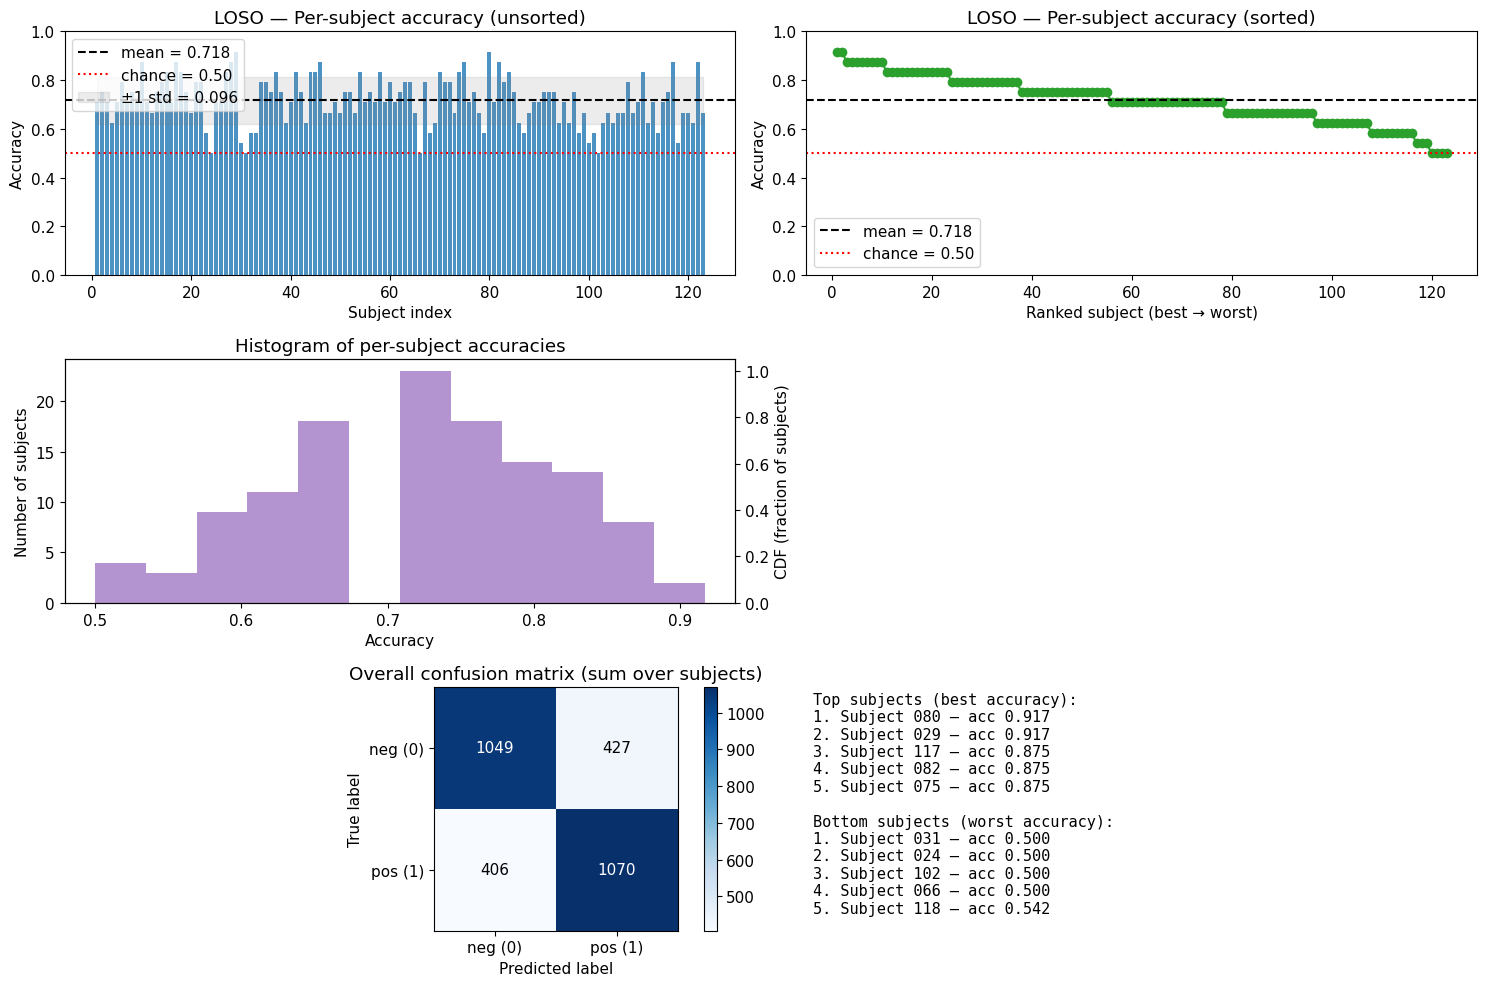


LOSO summary: subjects = 123, mean_acc = 0.7178, std_acc = 0.0961
Top 5 subjects (index, accuracy):
  subj 080 — 0.917
  subj 029 — 0.917
  subj 117 — 0.875
  subj 082 — 0.875
  subj 075 — 0.875
Bottom 5 subjects:
  subj 031 — 0.500
  subj 024 — 0.500
  subj 102 — 0.500
  subj 066 — 0.500
  subj 118 — 0.542


In [26]:
# Basic stats
acc = np.array(subject_accuracies)            # shape (N_subjects,)
N = acc.size
mean_acc = acc.mean()
std_acc  = acc.std()
chance = 0.5   # binary classification chance level (adjust if needed)

# Build overall confusion if not already
if 'overall_confusion' in globals():
    overall_conf = overall_confusion
else:
    overall_conf = np.sum(all_confusions, axis=0)

# Create figure with multiple subplots
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(15, 10))

# 1) Per-subject accuracy (unsorted)
ax1 = plt.subplot2grid((3,4),(0,0), colspan=2)
subjects = np.arange(1, N+1)
ax1.bar(subjects, acc, color='tab:blue', alpha=0.8)
ax1.axhline(mean_acc, color='k', linestyle='--', label=f"mean = {mean_acc:.3f}")
ax1.axhline(chance, color='r', linestyle=':', label=f"chance = {chance:.2f}")
ax1.fill_between(subjects, mean_acc - std_acc, mean_acc + std_acc, color='gray', alpha=0.15, label=f"±1 std = {std_acc:.3f}")
ax1.set_xlabel("Subject index")
ax1.set_ylabel("Accuracy")
ax1.set_title("LOSO — Per-subject accuracy (unsorted)")
ax1.set_ylim(0, 1.0)
ax1.legend(loc='upper left')

# 2) Per-subject accuracy (sorted)
ax2 = plt.subplot2grid((3,4),(0,2), colspan=2)
sorted_idx = np.argsort(acc)[::-1]    # descending
acc_sorted = acc[sorted_idx]
ax2.plot(np.arange(1, N+1), acc_sorted, marker='o', linestyle='-', color='tab:green')
ax2.axhline(mean_acc, color='k', linestyle='--', label=f"mean = {mean_acc:.3f}")
ax2.axhline(chance, color='r', linestyle=':', label=f"chance = {chance:.2f}")
ax2.set_xlabel("Ranked subject (best → worst)")
ax2.set_ylabel("Accuracy")
ax2.set_title("LOSO — Per-subject accuracy (sorted)")
ax2.set_ylim(0, 1.0)
ax2.legend(loc='lower left')

# 3) Histogram + CDF
ax3 = plt.subplot2grid((3,4),(1,0), colspan=2)
counts, bins, patches = ax3.hist(acc, bins=12, density=False, alpha=0.7, color='tab:purple')
ax3.set_xlabel("Accuracy")
ax3.set_ylabel("Number of subjects")
ax3.set_title("Histogram of per-subject accuracies")
# CDF on twin axis
ax3b = ax3.twinx()
cdf = np.cumsum(counts) / counts.sum()
# plot CDF at bin centers
bin_centers = 0.5*(bins[:-1] + bins[1:])

ax3b.set_ylabel("CDF (fraction of subjects)")
ax3b.set_ylim(0, 1.05)


# Confusion matrix heatmap (overall)
ax6 = plt.subplot2grid((3,4),(2,0), colspan=2)
cm = overall_conf.astype(int)
im = ax6.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax6.set_title("Overall confusion matrix (sum over subjects)")
plt.colorbar(im, ax=ax6, fraction=0.046, pad=0.04)
classes = ['neg (0)', 'pos (1)']   # adjust if your labels differ
tick_marks = np.arange(len(classes))
ax6.set_xticks(tick_marks)
ax6.set_yticks(tick_marks)
ax6.set_xticklabels(classes)
ax6.set_yticklabels(classes)
ax6.set_ylabel('True label')
ax6.set_xlabel('Predicted label')

# Add numbers in cells
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax6.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# 7) Top/bottom subjects printout on the figure (right side text)
top_k = 5
top_idx = sorted_idx[:top_k]
bot_idx = sorted_idx[-top_k:][::-1]  # worst first
# Put text box
ax_text = plt.subplot2grid((3,4),(2,2), colspan=2)
ax_text.axis('off')
txt = "Top subjects (best accuracy):\n"
for i, s in enumerate(top_idx, 1):
    txt += f"{i}. Subject {s+1:03d} — acc {acc[s]:.3f}\n"
txt += "\nBottom subjects (worst accuracy):\n"
for i, s in enumerate(bot_idx, 1):
    txt += f"{i}. Subject {s+1:03d} — acc {acc[s]:.3f}\n"
ax_text.text(0.01, 0.98, txt, fontsize=11, va='top', family='monospace')

plt.tight_layout()
plt.show()

# Print summary numbers in console as well
print(f"\nLOSO summary: subjects = {N}, mean_acc = {mean_acc:.4f}, std_acc = {std_acc:.4f}")
print(f"Top {top_k} subjects (index, accuracy):")
for s in top_idx:
    print(f"  subj {s+1:03d} — {acc[s]:.3f}")
print(f"Bottom {top_k} subjects:")
for s in bot_idx:
    print(f"  subj {s+1:03d} — {acc[s]:.3f}")


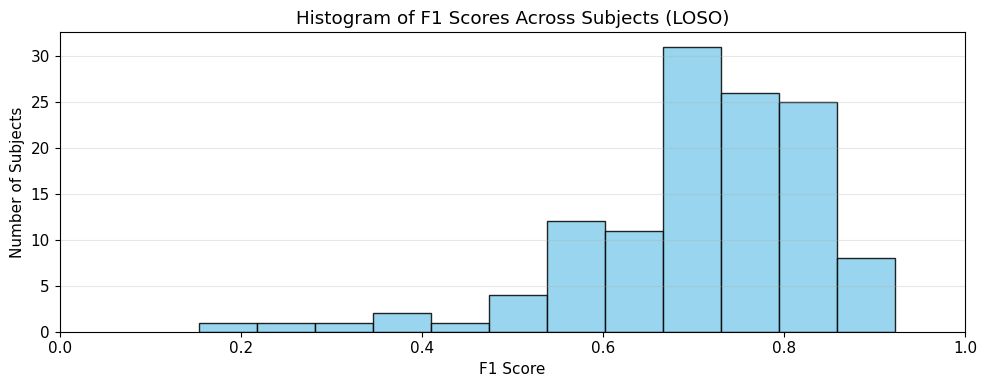


===== LOSO F1 Summary =====
Mean F1: 0.707
Std Dev: 0.132

Top Subjects by F1:
  1. Subject 080 — F1=0.923, Acc=0.917
  2. Subject 029 — F1=0.923, Acc=0.917
  3. Subject 122 — F1=0.889, Acc=0.875
  4. Subject 017 — F1=0.889, Acc=0.875
  5. Subject 046 — F1=0.870, Acc=0.875

Worst Subjects by F1:
  1. Subject 030 — F1=0.154, Acc=0.542
  2. Subject 066 — F1=0.250, Acc=0.500
  3. Subject 032 — F1=0.286, Acc=0.583
  4. Subject 087 — F1=0.375, Acc=0.583
  5. Subject 004 — F1=0.400, Acc=0.625


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Expected available variables:
# - all_confusions  (list of N confusion matrices from LOSO)
# - subject_accuracies (list or array, used only for summary printing)

acc = np.array(subject_accuracies)
N = acc.size

# ----------------------------------------------------
# Compute per-subject F1 from confusion matrices
# ----------------------------------------------------
f1_per_subj = np.zeros(N)

for i, cm in enumerate(all_confusions):
    cm = np.array(cm)

    tn, fp = cm[0,0], cm[0,1]
    fn, tp = cm[1,0], cm[1,1]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    f1_per_subj[i] = f1

# ----------------------------------------------------
# Plot 1 — Histogram of F1 Scores
# ----------------------------------------------------
plt.figure(figsize=(10,4))
plt.hist(f1_per_subj, bins=12, color='skyblue', edgecolor='black', alpha=0.85)
plt.title("Histogram of F1 Scores Across Subjects (LOSO)")
plt.xlabel("F1 Score")
plt.ylabel("Number of Subjects")
plt.xlim(0,1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



# ----------------------------------------------------
# Text Summary
# ----------------------------------------------------
top_k = 5

print("\n===== LOSO F1 Summary =====")
print(f"Mean F1: {f1_per_subj.mean():.3f}")
print(f"Std Dev: {f1_per_subj.std():.3f}")

print("\nTop Subjects by F1:")
for r in range(top_k):
    idx = sorted_idx[r]
    print(f"  {r+1}. Subject {idx+1:03d} — F1={f1_per_subj[idx]:.3f}, Acc={acc[idx]:.3f}")

print("\nWorst Subjects by F1:")
for r in range(top_k):
    idx = sorted_idx[-(r+1)]
    print(f"  {r+1}. Subject {idx+1:03d} — F1={f1_per_subj[idx]:.3f}, Acc={acc[idx]:.3f}")


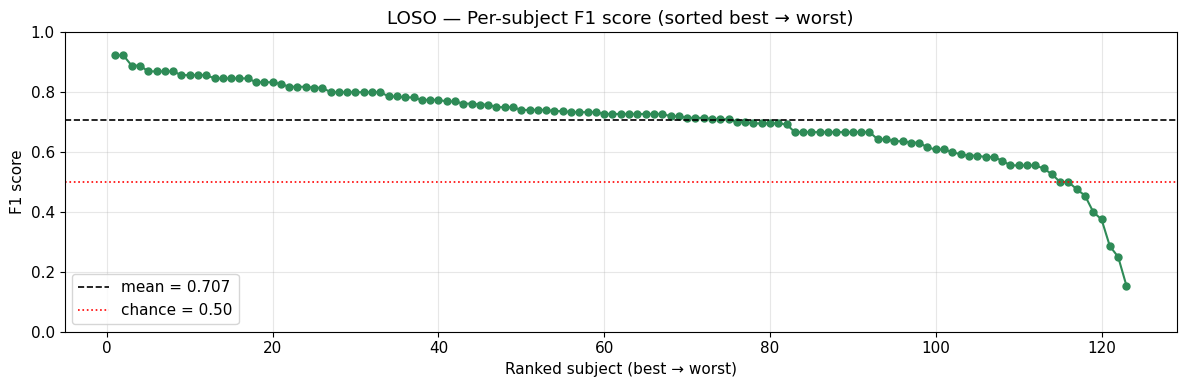


===== LOSO F1 SUMMARY =====
Mean F1: 0.707
Std Dev: 0.132

Top subjects by F1:
  1. Subject 080 — F1=0.923
  2. Subject 029 — F1=0.923
  3. Subject 122 — F1=0.889
  4. Subject 017 — F1=0.889
  5. Subject 046 — F1=0.870

Worst subjects by F1:
  1. Subject 030 — F1=0.154
  2. Subject 066 — F1=0.250
  3. Subject 032 — F1=0.286
  4. Subject 087 — F1=0.375
  5. Subject 004 — F1=0.400


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Inputs needed:
# - f1_per_subj : array of F1 scores
# - subject_accuracies : optional, for printing summary

f1 = np.array(f1_per_subj)
N = len(f1)

# Sort F1 best → worst
sorted_idx = np.argsort(f1)[::-1]
f1_sorted = f1[sorted_idx]

mean_f1 = f1.mean()
chance = 0.50   # binary baseline (optional)

# -------------------------------
# PLOT: Ranked scatter line curve
# -------------------------------
plt.figure(figsize=(12,4))

plt.plot(
    np.arange(1, N+1), f1_sorted,
    marker='o', markersize=5,
    linestyle='-', linewidth=1.5,
    color='seagreen'
)

# Mean line
plt.axhline(mean_f1, linestyle='--', color='black', linewidth=1.2,
            label=f"mean = {mean_f1:.3f}")

# Chance line
plt.axhline(chance, linestyle=':', color='red', linewidth=1.2,
            label=f"chance = {chance:.2f}")

plt.title("LOSO — Per-subject F1 score (sorted best → worst)")
plt.xlabel("Ranked subject (best → worst)")
plt.ylabel("F1 score")
plt.ylim(0, 1.0)
plt.grid(alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

# -------------------------------
# Text summary
# -------------------------------
top_k = 5
print("\n===== LOSO F1 SUMMARY =====")
print(f"Mean F1: {mean_f1:.3f}")
print(f"Std Dev: {f1.std():.3f}")

print("\nTop subjects by F1:")
for r in range(top_k):
    idx = sorted_idx[r]
    print(f"  {r+1}. Subject {idx+1:03d} — F1={f1[idx]:.3f}")

print("\nWorst subjects by F1:")
for r in range(top_k):
    idx = sorted_idx[-(r+1)]
    print(f"  {r+1}. Subject {idx+1:03d} — F1={f1[idx]:.3f}")
